# Загрузка зависимостей проекта

Установка optuna для оптимизации вычислений на гиперпараметрах

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.0 MB/s eta 0:00:00


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


# Препроцессинг
from sklearn.preprocessing import StandardScaler, PowerTransformer


# Статистические данные
from scipy import stats
from scipy.stats import randint

# Прогнозирование будущих параметров
from sklearn.feature_selection import mutual_info_regression


# Организация пайплайнов
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config


# Алгоритмы (в том числе и оптимизаторы)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression # Don't use it. (This is a multiclass classification problem)
from sklearn.svm import SVC


# Обучаемые модели
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice



# Для замера времени выполнения
import time

# определим изначальное значение для random, чтобы можно было воспроизводить идентичные значения на обучении
random_state = 42

# Загрузка датасета и его анализ

Загрузка датасета

In [3]:
# Чтение данных
milk_data = pd.read_csv("milk_dataset_1.csv")

# Зарезервируем данные для работы с пайплайнами
pipe_data = milk_data.copy()

# Для предварительного анализа
train_df = milk_data.copy()

train_df.head(10)

,Proteins (g),Fats (g),Carbohydrates (g),Calories,Days until the end of the shelf life,Weight (kg),Height (cm),Age,Physique,Individual intolerance,Usefulness of the product for humans
0,2.9,2.5,4.7,53.0,10,70,175,25,2,1,0
1,2.9,2.5,4.7,53.0,9,58,163,32,1,1,0
2,2.9,2.5,4.7,53.0,8,85,187,40,3,1,0
3,2.9,2.5,4.7,53.0,7,62,158,19,3,1,0
4,2.9,2.5,4.7,53.0,6,90,195,45,2,1,0
5,2.9,2.5,4.7,53.0,5,55,170,52,1,1,0
6,2.9,2.5,4.7,53.0,4,48,160,14,1,1,0
7,2.9,2.5,4.7,53.0,3,106,200,68,1,1,0
8,2.9,2.5,4.7,53.0,2,73,157,75,4,1,0
9,2.9,2.5,4.7,53.0,1,39,135,12,1,1,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Proteins (g)                          184 non-null    float64
 1   Fats (g)                              184 non-null    float64
 2   Carbohydrates (g)                     184 non-null    float64
 3   Calories                              184 non-null    float64
 4   Days until the end of the shelf life  184 non-null    int64  
 5   Weight (kg)                           184 non-null    int64  
 6   Height (cm)                           184 non-null    int64  
 7   Age                                   184 non-null    int64  
 8   Physique                              184 non-null    int64  
 9   Individual intolerance                184 non-null    int64  
 10  Usefulness of the product for humans  184 non-null    int64  
dtypes: float64(4), int6

Наш датасет изначально хороший, т.к. не имеет плохих или испорченных строчек в первом приближении (т.е. каждая строчка заполнена соответствующими параметрами)

## Статистический анализ датасета

In [6]:
# Статистика по числовым значениям поля
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Proteins (g),184.0,2.641304,0.487584,2.0,2.0,2.9,3.1,3.1
Fats (g),184.0,2.280435,1.821681,0.1,0.1,2.5,4.5,4.5
Carbohydrates (g),184.0,4.767935,0.046800,4.7,4.7,4.8,4.8,4.8
Calories,184.0,51.201087,16.961474,31.0,31.0,53.0,72.0,72.0
Days until the end of the shelf life,184.0,4.277174,3.057611,-1.0,2.0,3.0,7.0,11.0
Weight (kg),184.0,67.739130,15.981458,39.0,58.0,70.0,73.0,106.0
Height (cm),184.0,168.875000,16.088574,135.0,158.0,170.0,175.0,200.0
Age,184.0,37.179348,22.324370,9.0,19.0,25.0,52.0,103.0
Physique,184.0,2.157609,1.014726,1.0,1.0,2.0,3.0,4.0
Individual intolerance,184.0,0.163043,0.370413,0.0,0.0,0.0,0.0,1.0


Преименуем столбцы для удобства

In [17]:
train_df.rename(columns = {
        "Proteins (g)" : "Proteins",
        "Fats (g)" : "Fats",
        "Carbohydrates (g)" : "Carbohydrates",
        "Days until the end of the shelf life" : "EndDays",
        "Weight (kg)" : "Weight",
        "Height (cm)" : "Height",
        "Individual intolerance" : "Iintolerance",
        "Usefulness of the product for humans" : "Usefulness"
    },
    inplace=True #данные переименовываются на месте, копия объекта не создается
)
train_df

,Proteins,Fats,Carbohydrates,Calories,EndDays,Weight,Height,Age,Physique,Iintolerance
0,2.9,2.5,4.7,53.0,10,70,175,25,2,1
1,2.9,2.5,4.7,53.0,9,58,163,32,1,1
2,2.9,2.5,4.7,53.0,8,85,187,40,3,1
3,2.9,2.5,4.7,53.0,7,62,158,19,3,1
4,2.9,2.5,4.7,53.0,6,90,195,45,2,1
...,...,...,...,...,...,...,...,...,...,...
179,2.0,0.1,4.8,31.0,7,62,158,25,4,0
180,2.0,0.1,4.8,31.0,7,62,158,40,4,0
181,2.0,0.1,4.8,31.0,7,62,158,60,4,0
182,2.0,0.1,4.8,31.0,7,62,158,85,4,0


Численная статистика помогает для первичного предположения о распределении значений, так заметим, что:
- Значений калорий распределены неравномерно (вероятно обладает рядом пиков)
- Параметры людей подобраны так, что основное количество выборки приходится на среднестатистическую комплекцию человека

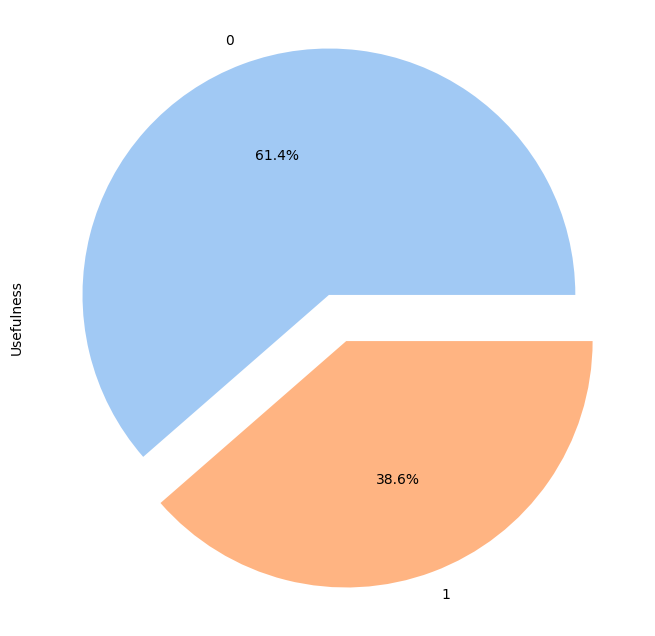

In [8]:
#Target Distribution
plt.figure(figsize=(8,8))
palette_color = sns.color_palette('pastel')
explode = [0.1, 0.1]
train_df.groupby('Usefulness')['Usefulness'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%");


Результаты датасета дисбалансированы, можем получить недостоверное обучение на выходе. Есть несколько техник чтобы работать с несбалансированными датасетами (например, недостаточная выборка, избыточная выборка, установление порогового значения вероятности и корректировка веса). Однако, сделаем предположение, что здесь это не нужно.

## Группировка значений для предобработки

Для разных типов данных требуется разная предобработка значений (к примеру может быть выгодно использовать разные функции активации), чтобы основную массу значений привести к наибольшему отзыву от ML

In [9]:
train_df.columns

Index(['Proteins', 'Fats', 'Carbohydrates', 'Calories', 'EndDays', 'Weight',
       'Height', 'Age', 'Physique', 'Iintolerance', 'Usefulness'],
      dtype='object')

In [10]:
## распределим значения на бинарные и не бинарные
all_features = list(set(train_df.columns) - set('Iintolerance'))
continuous_features = ['Proteins', 'Fats', 'Carbohydrates', 'Calories', 'EndDays', 'Weight', 'Height', 'Age', 'Physique']
binary_features = ['Iintolerance']

## Графики

Проанализируем каждую из орт входящей выбрки относительно корреляции к итоговому значению.

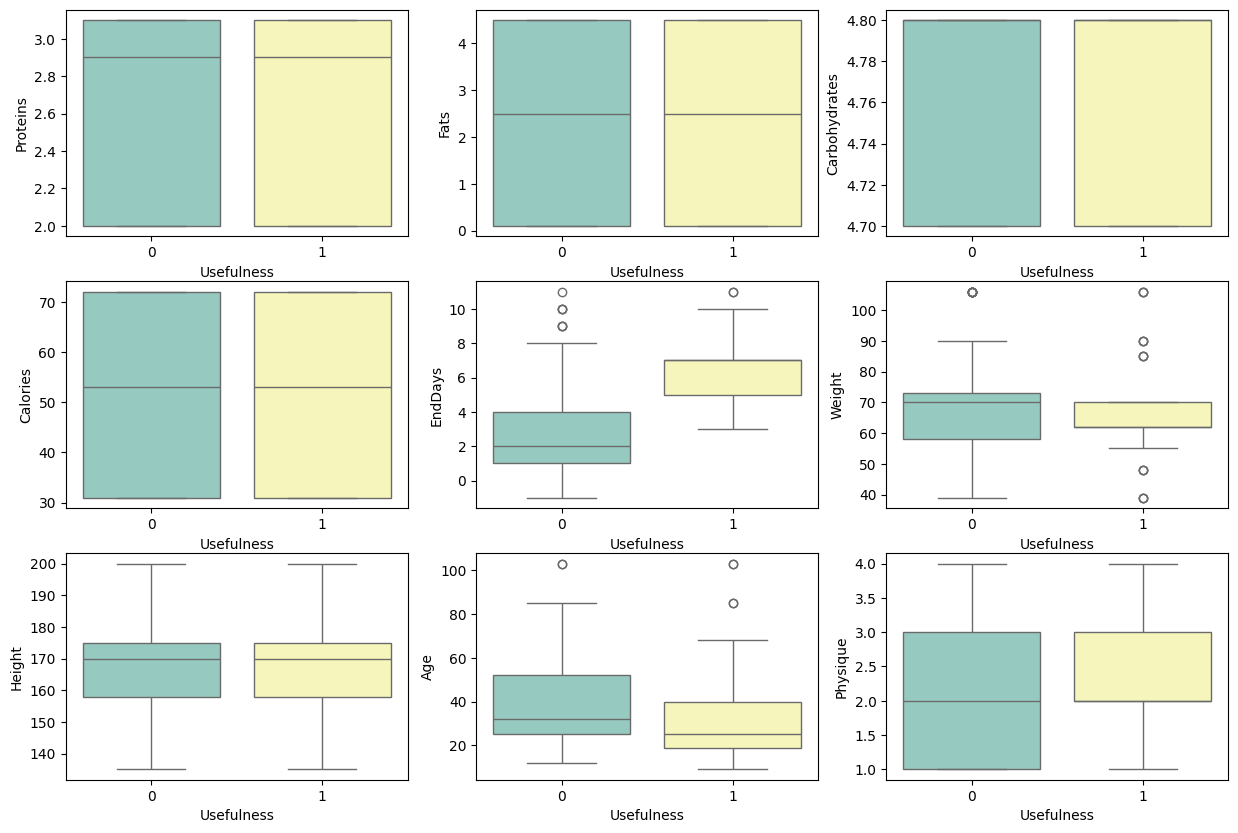

In [11]:
fig, ax = plt.subplots(3, len(continuous_features)//3, figsize=(15, 10))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Usefulness', y=var, data=train_df, ax=subplot, palette='Set3')

Наблюдения:
- Можем заметить, что в действительности параметры молока имеют нормальное распределение и вероятно наименьшую корреляцию с результатом. Можем предположить, что основное влияние на восприятие человеком зависит лишь от самого человека вне зависимости от состава молока.
- Можем заметить, что чем меньше срок годности молока, тем больше вероятность что оно не пригодно для употребления.
- Также прослеживается корреляция с возрастом человека, чем он старше тем вероятнее, что молоко для него не будет полезным, но данную зависимость не следует рассматривать как линейную, т.к. возростное ограничение гипотетически может зависить и от ферментов в молоке и возраста, поэтому данное предположение требует отдельного анализа

Теперь рассмотрим зависимость от бинарных данных

<Axes: xlabel='Usefulness', ylabel='Iintolerance'>

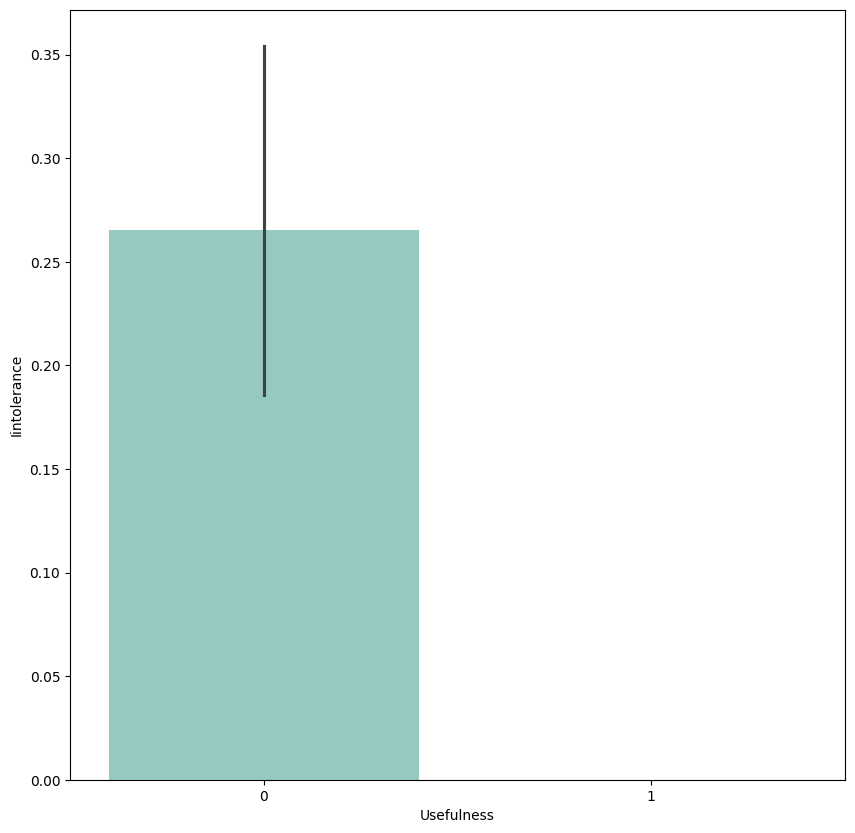

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x='Usefulness', y=binary_features[0], data=train_df, ax=ax, palette='Set3')

Наблюдения:
- Бинарные данные как правило имеют наибольший вклад в решение, т.к. однозначно включают или выключают орты по определённым метрикам. Здесь мы можем заметить однозначную корреляцию от непереносимости молока и результатом. Скорее этот параметр будет иметь наибольший вес в определении, т.к. мы можем проследить однозначную линейную зависимость.

In [13]:
df_slice = train_df.iloc[45:48]
df_brain_storm=df_slice.drop('Usefulness', axis = 1)
df_brain_storm

,Proteins,Fats,Carbohydrates,Calories,EndDays,Weight,Height,Age,Physique,Iintolerance
45,2.9,2.5,4.7,53.0,2,90,195,45,2,0
46,2.9,2.5,4.7,53.0,2,55,170,52,1,0
47,2.9,2.5,4.7,53.0,2,48,160,14,1,0


## Корреляция

Давайте посмотрим на взаимосвязь между функциями и целью более количественно.

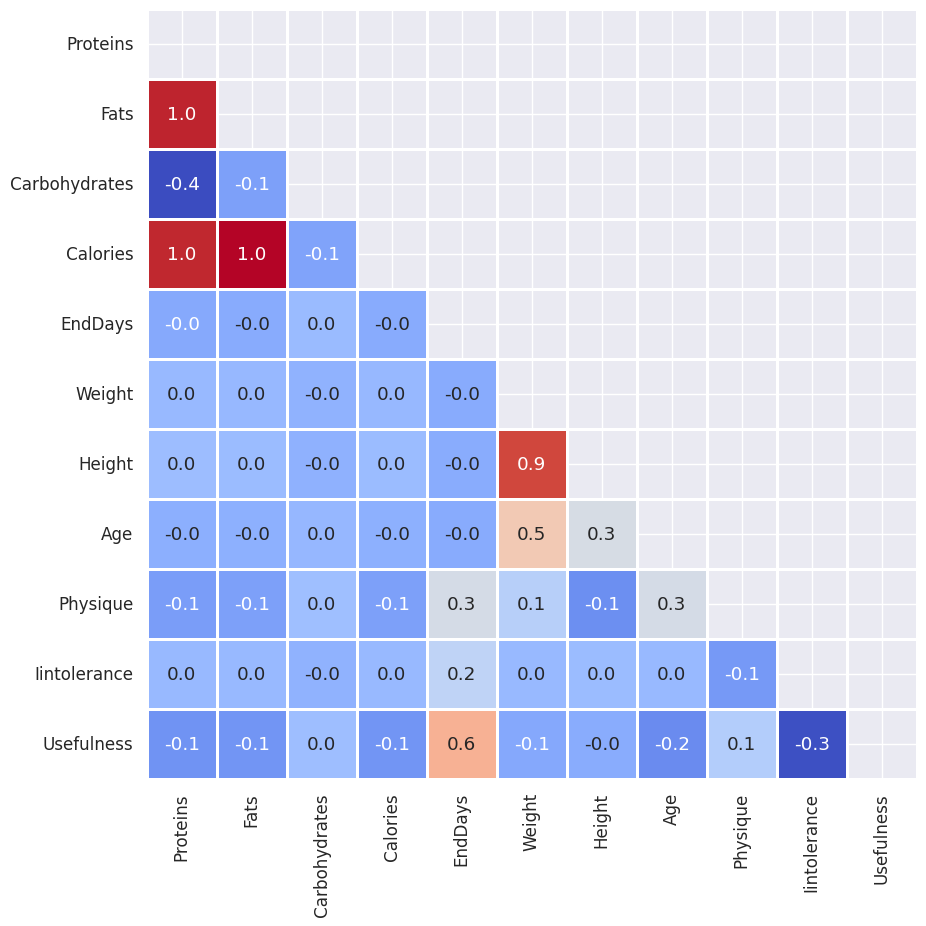

In [14]:
# Display correlations between features and quality Usefulness on heatmap.

sns.set(font_scale=1.1)
correlation_train = train_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

У нас есть представление линейной корреляции между параметрами и мы можем заметить, что жиры, калории и протеины обладают тесной взаимосвязью, однако остальные параматры имерю очень низкую корреляцию. Итог - искать корреляцию в задаче классификации не правильно, т.к. зависимость в общем случае связанно с каждым из параметров. Корреляция хороша для измерения линейных отношений. И мы просим измерить взаимосвязь между непрерывными и дискретными или дискретными и дискретными переменными. Так мы можем проанализировать к примеру состав молока, но данное решение плохо подходит для исследования в задачах классификации.

Однако, мы можем выявить и проверить наши гипотезы о наиболее влиятельных параметрах на конечных результат. Так, заметим, что срок хранения и не переносимость человеком лактозы действительно имеет наибольший вес на итоговый результат, по отношению к остальным параметрам входных данных.

In [15]:
y= train_df['Usefulness']
train_df = train_df.drop(['Usefulness'], axis=1)
train_df.head()

,Proteins,Fats,Carbohydrates,Calories,EndDays,Weight,Height,Age,Physique,Iintolerance
0,2.9,2.5,4.7,53.0,10,70,175,25,2,1
1,2.9,2.5,4.7,53.0,9,58,163,32,1,1
2,2.9,2.5,4.7,53.0,8,85,187,40,3,1
3,2.9,2.5,4.7,53.0,7,62,158,19,3,1
4,2.9,2.5,4.7,53.0,6,90,195,45,2,1


In [18]:
# Определим итоговую корреляцию к итоговой переменной.

mutual_info = mutual_info_regression(train_df, y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = train_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Mutual_Information"] ).style.background_gradient("cool")


,Mutual_Information
EndDays,0.276991
Iintolerance,0.088845
Calories,0.022376
Age,0.018820
Height,0.007028
Carbohydrates,0.005608
Proteins,0.000000
Fats,0.000000
Weight,0.000000
Physique,0.000000


Здесь мы также подтвердим, что наше предположение об испорченном молоке имеет значимую корреляцию с конечным результатом.

# Предобработка датасета

У нас очень чистый набор данных без пропущенных значений

* Во-первых: некоторым алгоритмам требуется масштабирование функций для большей точности и более быстрой сходимости (в частности, алгоритмы на основе расстояния, такие как KNN и машина опорных векторов, а также любые другие алгоритмы, использующие градиентный спуск, такие как ANN). Вот почему нам нужно масштабировать для них непрерывные функции.
* Во-вторых: асимметрия набора данных может повлиять на производительность алгоритма. Мы будем выявлять и обрабатывать искаженные функции.

Для этой цели будем использовать крошечный конвейер. Пайплайны хороши по следующим причинам:

* Они помогают избежать любой утечки данных при преобразованиях с сохранением состояния, которая в конечном итоге может привести к переобучению.
* Нет необходимости вручную отслеживать этапы предварительной обработки в обучающих и тестовых наборах.
* В итоге вы получаете готовую к развертыванию модель

Древовидные алгоритмы (например, дерево классификации, случайный лес, GBM, XGBoost) не требуют масштабирования. Поэтому я использовала конвейер предварительной обработки только с SVR, KNN и ANN.

Теперь определим кривизну графиков распределения занчений

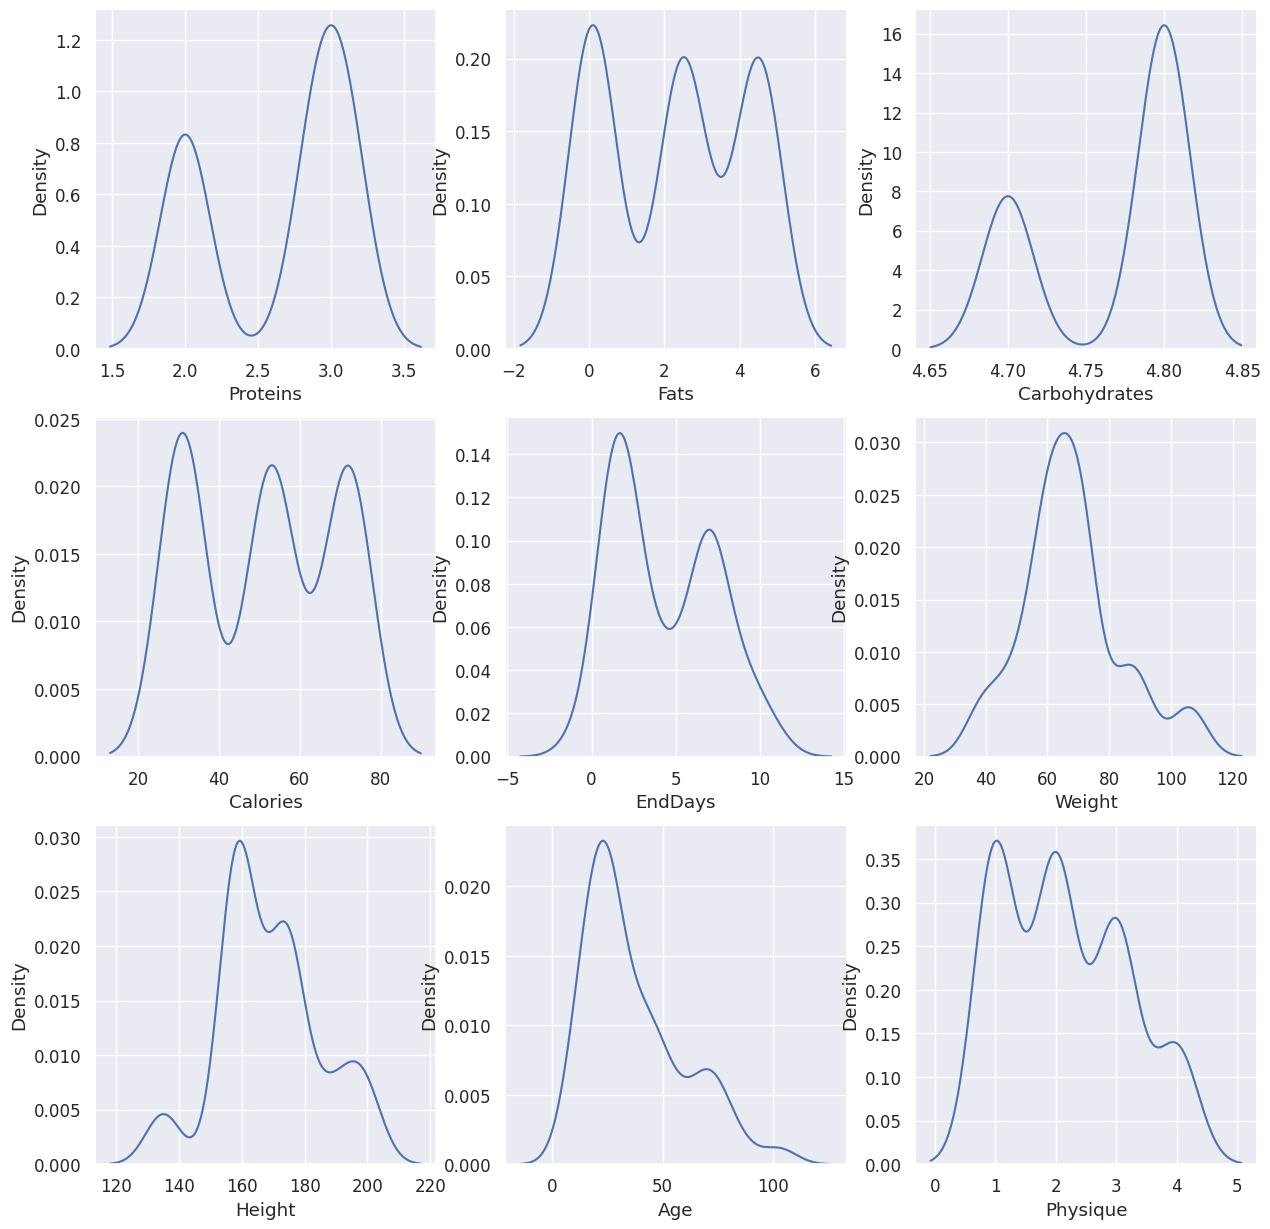

In [19]:
fig, ax = plt.subplots(3, len(continuous_features)//3, figsize=(15, 15))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.kdeplot(x=var, data=train_df, ax=subplot, palette='Set3')

Мы оказались правы, данные по калорием обладают значимыми колебаниями в занчениях.

In [20]:
# Посмотрим на кривизну через числовые критерии
skew_features = train_df[continuous_features].skew().sort_values(ascending=False)
skew_features = pd.DataFrame({'Skew' : skew_features})
skew_features.style.background_gradient('rocket')

,Skew
Age,1.020436
Weight,0.605428
Physique,0.376391
EndDays,0.351055
Height,0.139196
Calories,-0.014594
Fats,-0.035108
Proteins,-0.509569
Carbohydrates,-0.774865


In [21]:
#skewed and non-skewed features
skewed_features = ['Height', 'EndDays', 'Fats', 'Calories', 'Physique']
non_skewed_feature = ['Carbohydrates', 'Proteins', 'Age', 'Weight']

# skewed_features = ['Proteins', 'Carbohydrates', 'Age', 'EndDays', 'Physique']
# non_skewed_feature = ['Fats', 'Weight', 'Calories', 'Height']

Sklearn имеет множество полезных функций для предварительной обработки. Мы можем использовать PowerTransformer, чтобы избавиться от асимметрии. PowerTransformer также имеет аргумент стандартизации. Мы можем установить для него значение True, чтобы выполнить нашу вторую задачу: масштабирование.

In [22]:
skewness_transformer = Pipeline(steps=[
    ('PowerTransformer', PowerTransformer( method='yeo-johnson', standardize=True)),
])

Давайте создадим еще одну часть, которая будет обрабатывать наши функции с устраивающей нас кривизной, которые не будут искажены. Для этого будет достаточно только масштабирования.

In [23]:
# Стандартизируем функции, удалив среднее значение и масштабируя его до единичной дисперсии.
numerical_transformer = Pipeline(steps=[
    ('Scaller', StandardScaler()),
])


Создадим пайплайн сборки из ранее заготовленных блоков

In [24]:
preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('skewness_transformer', skewness_transformer, skewed_features),
        ('numerical_transformer', numerical_transformer, non_skewed_feature)
    ])
set_config(display="diagram")
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('skewness_transformer',
                                 Pipeline(steps=[('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['Height', 'EndDays', 'Fats', 'Calories',
                                  'Physique']),
                                ('numerical_transformer',
                                 Pipeline(steps=[('Scaller',
                                                  StandardScaler())]),
                                 ['Carbohydrates', 'Proteins', 'Age',
                                  'Weight'])])

Создадим наборы тренировочной выборки и тестов. Обратите внимание на аргумент «расслоение». Это поможет разделить обучающие и тестовые наборы таким образом, чтобы распределение классов качества в этих наборах было одинаковым. Это важно для несбалансированных наборов данных.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y,
                                                    test_size=0.2,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)

print(X_train.shape, X_test.shape)

(147, 10) (37, 10)


## Модели

### Дерево решений

Дерево решений - один из лучших алгоритмов для классификации, т.к. он наиболее точно определяет корреляцию конечного решения от входных параметров

In [26]:
DT_model = DecisionTreeClassifier(random_state = random_state).fit(X_train, y_train)
train_accuracy = round(DT_model.score(X_train, y_train)*100,2)
print("Training Accuracy: % {}".format(train_accuracy))

Training Accuracy: % 100.0


In [27]:
test_accuracy = round(DT_model.score(X_test,y_test)*100,2)
print("Testing Accuracy: % {}".format(test_accuracy))

Testing Accuracy: % 94.59


Как результат мы получили высокую точность определения

In [28]:
X_test.columns

Index(['Proteins', 'Fats', 'Carbohydrates', 'Calories', 'EndDays', 'Weight',
       'Height', 'Age', 'Physique', 'Iintolerance'],
      dtype='object')

Отобразим результирующее дерево

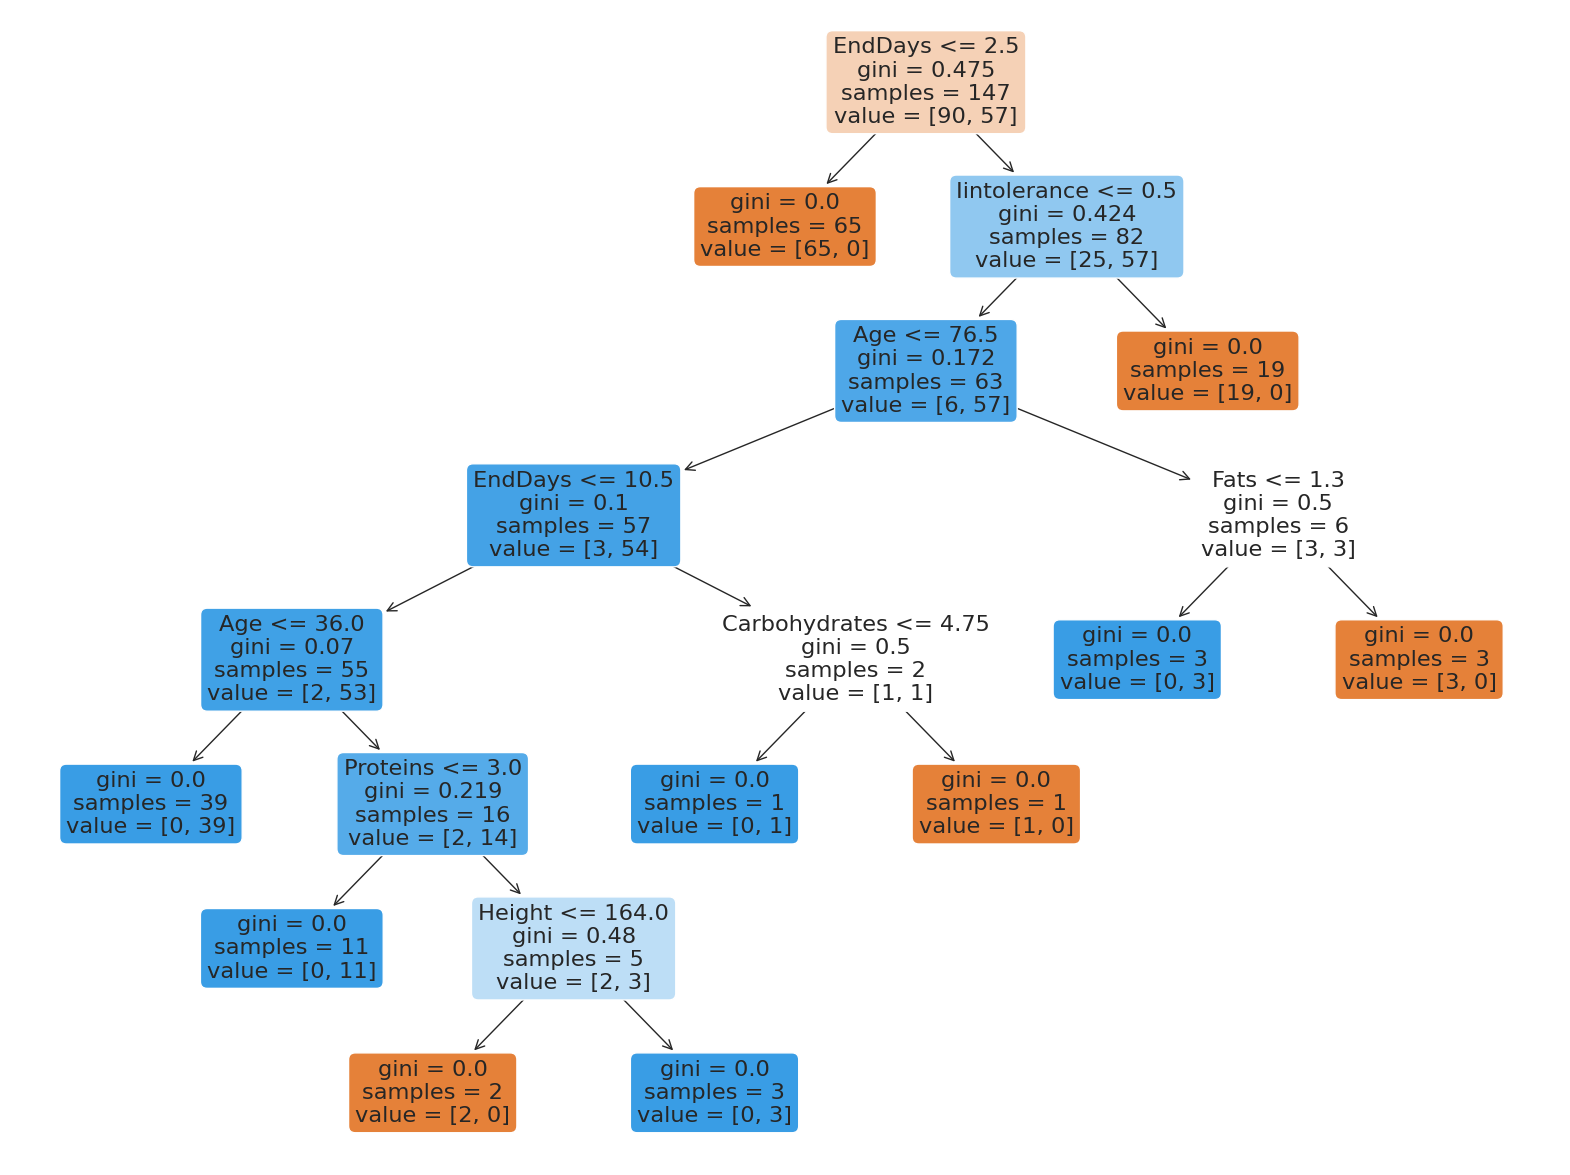

In [29]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,15))

plot_tree(DT_model, filled= True, rounded = True, feature_names= X_train.columns);

Как мы ранее и предпологали, непереносимость лактозы оказывает наибольшее влияние.

Так по дереву можно сказать, что в случае если у человека есть непереносимость лактозы, то употреблять ему молоко однозначно не стоит.
Если же противопоказаний нет, то стоит оценить возраст, т.к. более пожилые люди плохо переносят молочные продукты и наконец, последний наиболее важный фактор - это срок годности

In [30]:
 	# Proteins 	Fats 	Carbohydrates 	Calories 	EndDays 	Weight 	Height 	Age 	Physique 	Iintolerance 	Usefulness
 	# 2.9 	2.5 	4.7 	53.0 	10 	70 	175 	25 	2 	1 	0
input = pd.DataFrame( {
        "Proteins" : [2.9],
        "Fats" : [2.5],
        "Carbohydrates" : [4.7],
        "Calories" : [53.0],
        "EndDays" : [53.0],
        "Weight" : [71],
        "Height" : [185],
        "Age" : [21],
        "Physique" : [1],
        "Iintolerance" : [0]
    }
)

"Можно" if (DT_model.predict(input)[0]) else "Нельзя"

'Можно'

Устанавливаем готовую нейронную сеть tesseract для расспознования русского с картинки, её мы будем использовать вызывая через command line, с помощью subrocess, результат вывода получим с помощью обёртки stdout в Pipe

In [36]:
!pip install pytesseract

In [31]:
!sudo apt install tesseract-ocr-rus

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd tesseract-ocr-rus
0 upgraded, 4 newly installed, 0 to remove and 33 not upgraded.
Need to get 6,088 kB of archives.
After this operation, 19.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-rus all 1:4.00~git30-7274cfa-1.1 [1,271 kB]
Fetched 6,088 kB in 3s (2,245 kB/s)
debconf: unable to i

In [32]:
!sudo apt install tesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package tesseract


Определим фукции обработки изображения и постобработки вывода первой нейросети для входа второй, которую мы ранее уже обучили.

In [37]:
from PIL import Image
import pytesseract
import re
import subprocess


pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'

def image_to_str(path):
    #поиск текста на изображении
    result = subprocess.run(['tesseract', path, '-', '-l', 'rus'], stdout=subprocess.PIPE)
    return result.stdout.decode("utf-8")

def text_preprocessing(str):
    tables = {}

    match = re.search(r'\bбелк[аио]?в?\s?[—=-]?\s?[0123456789]+[,.\s]?[0123456789]', str, re.IGNORECASE) # выделяем белки
    if match:
        tmp_str_match=re.search(r'\b[0123456789]+[,.\s]?[0123456789]', match[0], re.IGNORECASE)
        tmp_str=tmp_str_match[0].replace(",",".")
        tables["Proteins"]=[float(tmp_str)]

    match = re.search(r'\bжир[аыов]?\s?[—=-]?\s?[0123456789]+[,.\s]?[0123456789]', str, re.IGNORECASE)  # выделяем жиры
    if match:
        tmp_str_match=re.search(r'\b[0123456789]+[,.\s]?[0123456789]', match[0], re.IGNORECASE)
        tmp_str=tmp_str_match[0].replace(",",".")
        tables["Fats"]=[float(tmp_str)]

    match = re.search(r'\b[жи]?р[аыов]?\s?[—=-]?\s?[0123456789]+[,.\s]?[0123456789]', str, re.IGNORECASE) # жиры
    if match:
        tmp_str_match=re.search(r'\b[0123456789]+[,.\s]?[0123456789]', match[0], re.IGNORECASE)
        tmp_str=tmp_str_match[0].replace(",",".")
        tables["Fats"]=[float(tmp_str)]

    match = re.search(r'\bуглевод[ыо]?в?\s?[—=-]?\s?[0123456789]+[,.\s]?[0123456789]', str, re.IGNORECASE) # углеводы
    if match:
        tmp_str_match=re.search(r'\b[0123456789]+[,.\s]?[0123456789]', match[0], re.IGNORECASE)
        tmp_str=tmp_str_match[0].replace(",",".")
        tables["Carbohydrates"]=[float(tmp_str)]

    match = re.search(r'[\d]+(.[\d]+)?\sккал', str, re.IGNORECASE)                                       # калорийность
    if match:
        tmp_str_match=re.search(r'[\d]+(.[\d]+)?', match[0], re.IGNORECASE)
        tmp_str=tmp_str_match[0].replace(",",".")
        tables["Calories"]=[float(tmp_str)]

    return tables


def process_data(image_path, additional_data):
    print(image_to_str(image_path))
    image_data = text_preprocessing(image_to_str(image_path))
    additional_data = { key:([value] if type(value) is not list else value) for key, value in additional_data.items()}
    data = image_data | additional_data

    input = pd.DataFrame(data)
    input.rename(columns = {
            "Срок окончания" : "EndDays",
            "Вес" : "Weight",
            "Рост" : "Height",
            "Возраст": "Age",
            "Телосложение": "Physique",
            "Непереносимость лактозы" : "Iintolerance"
        },
        inplace=True
    )
    input.reindex(
        ["Proteins","Fats","Carbohydrates","Calories","EndDays","Weight","Height","Age","Physique","Iintolerance"],
        axis=1
    )

    return "Можно" if (DT_model.predict(input)[0]) else "Нельзя"



Воспользуемся нашей итоговой функцией, которая читает состав молока с картинки и при введёных параметрах человека и срока годности молока, выдаёт нам решение стоит ли употреблять молоко или нет

In [38]:
process_data(
    "test.jfif",
    {
        "Срок окончания" : 3,
        "Вес" : 70,
        "Рост" : 180,
        "Возраст": 20,
        "Телосложение": 1,
        "Непереносимость лактозы" : 1
    }
)

 
 
 

 
 
   

МОЛОКО ПИТЬЕВОЕ
УЛЬТРАПАСТЕРИЗ0-.
ВАННОЕС МАССОВОИ
'ДОЛЕИ ЖИРА 0,5 %.

остав: молоко обезжиренное,
молоко цельное:
Пищевая ценность в.100 г
продукта:жиры — 0,5 г, белки —
3.0 т; углеводы = 4,7 г.
Энергетическая ценность
(калорийность) — 149 кДж/ 35 ккал:
Хранить притемпературе
0т+26'д0'+25`С5Продукт. во
вскрытой упаковкё” хранить при
температуре’ от +2" С’до-+6 С.
Дата производства, употребить до:
шт см: на крышке: <»
= 2 ГОСТ31450:20135 4
2%; , д №

_ Г Ме ны, о.
х ое з 5
= \ ба *

 

 

 

 

 

 

 

 

  

2 ПОТ
“мм ->

 

Е



'Нельзя'

## Сравнение производительности моделей

Проанализируем другие характеристики алгоритма. Восопльзуемся ранее созданным пайплайном для SVC, ANN и KNN. Добавем его поверх классификаторов, и они превратятся в конвейеры классификации.

In [39]:
SVC_pipe = Pipeline(steps=[
                       ('preprocessor', preprocessor),
                      ('regressor1', SVC(random_state =random_state)),
                     ])
SVC_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewness_transformer',
                                                  Pipeline(steps=[('PowerTransformer',
                                                                   PowerTransformer())]),
                                                  ['Height', 'EndDays', 'Fats',
                                                   'Calories', 'Physique']),
                                                 ('numerical_transformer',
                                                  Pipeline(steps=[('Scaller',
                                                                   StandardScaler())]),
                                                  ['Carbohydrates', 'Proteins',
                                                   'Age', 'Weight'])])),
                ('regressor1', SVC(random_state=42))])

In [40]:
KNN_pipe = Pipeline(steps=[
                       ('preprocessor', preprocessor),
                      ('regressor1', KNeighborsClassifier()),
                     ])
KNN_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewness_transformer',
                                                  Pipeline(steps=[('PowerTransformer',
                                                                   PowerTransformer())]),
                                                  ['Height', 'EndDays', 'Fats',
                                                   'Calories', 'Physique']),
                                                 ('numerical_transformer',
                                                  Pipeline(steps=[('Scaller',
                                                                   StandardScaler())]),
                                                  ['Carbohydrates', 'Proteins',
                                                   'Age', 'Weight'])])),
                ('regressor1', KNeighborsClassifier())])

Теперь мы сравним различные алгоритмы. Использование происходило с готовыми параметрами, в случае выявления аномалий в процессе работы возможна более точная настройка параментров работы.

Для сравнения с деревом решений были выбраны следующие алгоритмы:
1) SVm - метод опорных векторов - применяется для решения задач классификации и регрессии. Основная идея метода заключается в построении гиперплоскости, разделяющей объекты выборки оптимальным способом. Алгоритм работает в предположении, что чем больше расстояние (зазор) между разделяющей гиперплоскостью и объектами разделяемых классов, тем меньше будет средняя ошибка классификатора.
2) GBM - Градиентный бустинг - это техника машинного обучения для задач классификации и регрессии, которая строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений. Обучение ансамбля проводится последовательно. На каждой итерации вычисляются отклонения предсказаний уже обученного ансамбля на обучающей выборке. Следующая модель, которая будет добавлена в ансамбль будет предсказывать эти отклонения. Таким образом, добавив предсказания нового дерева к предсказаниям обученного ансамбля мы можем уменьшить среднее отклонение модели, которое является таргетом оптимизационной задачи. Новые деревья добавляются в ансамбль до тех пор, пока ошибка уменьшается, либо пока не выполняется одно из правил "ранней остановки".
3) XGBoost - одна из самых популярных и эффективных реализаций алгоритма градиентного бустинга на деревьях на 2019-й год.
4) LGBM облегчённый градиентный бустинг — эффективная реализацию ансамбля стохастического градиентного бустинга с открытым исходным кодом.
5) KNN - ближайших соседей (англ. k-nearest neighbors algorithm, k-NN) — метрический алгоритм для автоматической классификации объектов или регрессии. В случае использования метода для классификации объект присваивается тому классу, который является наиболее распространённым среди k {\displaystyle k} соседей данного элемента, классы которых уже известны. В случае использования метода для регрессии, объекту присваивается среднее значение по k {\displaystyle k} ближайшим к нему объектам, значения которых уже известны.
6) RF - Метод случайного леса - алгоритм машинного обучения, заключающийся в использовании ансамбля решающих деревьев. Алгоритм сочетает в себе две основные идеи: метод бэггинга Бреймана и метод случайных подпространств. Алгоритм применяется для задач классификации, регрессии и кластеризации. Основная идея заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается лучше, чем решающее дерево.

Алгоритм может быть применим к выборкам с большим количеством атрибутов (многомерным). Для этого перед применением нужно определить функцию расстояния; классический вариант такой функции — евклидова метрика

Произведём следующие действия
* По одной подберём модели к обучающим данным и используем их для прогнозов на тестовом наборе. Результаты добавим в списки.
* Список преобразуем во фрейм данных, чтобы упростить визуализацию.
* Для визуализации эффективности алгоритмов на тестовом наборе построим гистограмму.

[LightGBM] [Info] Number of positive: 57, number of negative: 90
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387755 -> initscore=-0.456758
[LightGBM] [Info] Start training from score -0.456758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

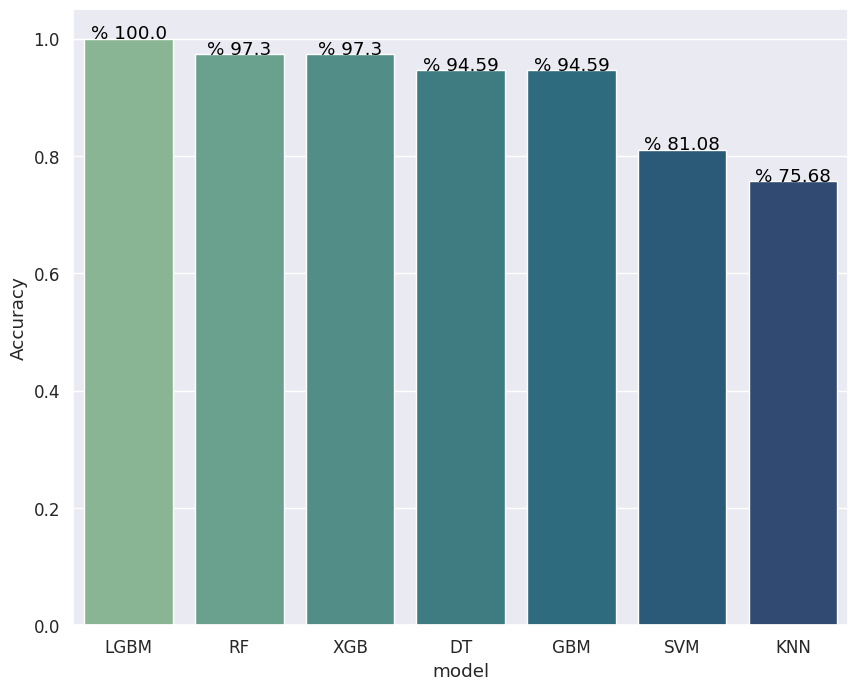

In [41]:
models = []
models.append(('DT', DecisionTreeClassifier(random_state = random_state)))
models.append(('SVM', SVC_pipe))
models.append(('RF', RandomForestClassifier(random_state = random_state)))
models.append(('GBM', GradientBoostingClassifier(random_state = random_state)))
models.append(('XGB', XGBClassifier(random_state = random_state)))
models.append(('LGBM', LGBMClassifier(random_state = random_state)))
models.append(('KNN', KNN_pipe))

accT = []
names = []

for name, model in models:

        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accT.append([name, accuracy_score(y_test, y_pred)])

results = pd.DataFrame(accT, columns = ['model', 'Accuracy'])
groupedvalues = results.sort_values(by = 'Accuracy', ascending = False).reset_index()

plt.figure(figsize=(10,8))
g = sns.barplot(x='model', y='Accuracy', data=groupedvalues, palette = "crest")

for index, row in groupedvalues.iterrows():
    g.text(row.name, row.Accuracy, "% {}".format(round(row.Accuracy*100,2)), color='black', ha="center")



plt.show()

У нас есть модель, предсказывающая с точностью 100% без какой-либо настройки гиперпараметров. Наиболее точным методом оказалась облегчённая модель градиентного бустинга LightGBM.
Можем заметить, что в действительности метод случайного леса, используя несколько реализаций деревьев решений получает лучший результат, нежели единственное дерево, которое также выдаёт не плохой результат в 94.59%.

Наихудший результат мы получили на модели K-ближайших соседей, т.к. в действительности этот метод работает лучше на более связных между собой данных с большим объёмом обучающего датасета.

In [42]:
Xgb_model = XGBClassifier(random_state = random_state).fit(X_train, y_train)
train_accuracy = round(Xgb_model.score(X_train, y_train)*100,2)
print("Training Accuracy: % {}".format(train_accuracy))

Training Accuracy: % 99.32


In [43]:
test_accuracy = round(Xgb_model.score(X_test,y_test)*100,2)
print("Testing Accuracy: % {}".format(test_accuracy))

Testing Accuracy: % 97.3


### XGBoost

Можем узнать, какие признаки были более важными при классификации по графикам важности признаков, для этого воспользуемся встроенной функцией XGBoost.


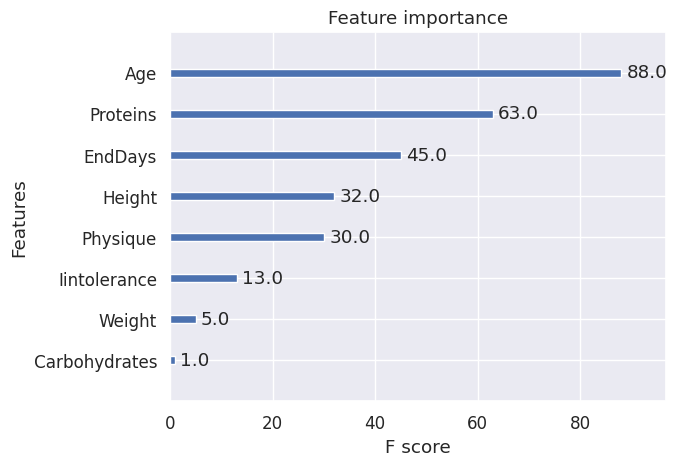

In [44]:
from xgboost import plot_importance
plot_importance(Xgb_model);

Можем заметить, при статистическом анализе мы также замечали, что возраст имеет прослеживаемую корреляцию. Однако, отметим, что в Xgb модели очень слабую вес получили параметры невосприимчивости молока и срок окончания годности, при этом модель смогла повысить точность своих резульатов, определив иную корреляцию компонент, нежели ранее произведённое ожидание, которое прослеживалось и в дереве решений.